,Dataset,Value
0,Number of features,11.00
1,Number of characters,23272.00
2,Number of Missing cells,56591.00
3,Percentage of Missing cells,22.11


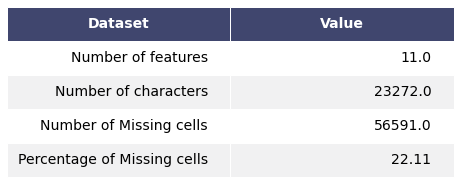

In [14]:
import pickle
import sys
sys.path.insert(1, '../src')
from render_table import render_table

dataset_overview_df = pickle.load(open("../results/tables/dataset_overview.pkl", "rb"))
feature_overview_df = pickle.load(open("../results/tables/feature_overview.pkl", "rb"))

render_table(dataset_overview_df, header_columns=0, col_width=4)
dataset_overview_df

![Alignment Over Time](../results/figures/alignment_over_time.png)
![Alignment Vs Features](../results/figures/alignment_vs_features.png)
![Alignment By Alignment](../results/figures/appearances_by_alignment.png)